In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import tensorflow as tf
from matplotlib import pyplot as pp
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from utils import fit_shapes, zscore

In [3]:
from plots import plot_text
from utils import ecdf

In [4]:
pr = np.load("tmp/pr_ci.npz")
print(pr.keys())

['zfactor', 'T', 'C', 'Y', 'Ys', 'params']


In [90]:
# D = np.abs(np.squeeze(pr['Ys'][5] - pr['T']))
D = np.squeeze(pr['Y'] - pr['T']) # bias errors
# D = np.squeeze(pr['U']) # variance
cores = 1

# find best distribution given a sample

In [6]:
dists = [
('alpha', sp.stats.alpha),
('anglit', sp.stats.anglit),
('arcsine', sp.stats.arcsine),
('beta', sp.stats.beta),
('betaprime', sp.stats.betaprime),
('bradford', sp.stats.bradford),
('burr', sp.stats.burr),
('cauchy', sp.stats.cauchy),
('chi', sp.stats.chi),
('chi2', sp.stats.chi2),
('cosine', sp.stats.cosine),
('dgamma', sp.stats.dgamma),
('dweibull', sp.stats.dweibull),
('erlang', sp.stats.erlang),
('expon', sp.stats.expon),
('exponnorm', sp.stats.exponnorm),
('exponweib', sp.stats.exponweib),
('exponpow', sp.stats.exponpow),
('f', sp.stats.f),
('fatiguelife', sp.stats.fatiguelife),
('fisk', sp.stats.fisk),
('foldcauchy', sp.stats.foldcauchy),
('foldnorm', sp.stats.foldnorm),
('frechet_r', sp.stats.frechet_r),
('frechet_l', sp.stats.frechet_l),
('genlogistic', sp.stats.genlogistic),
('gennorm', sp.stats.gennorm),
('genpareto', sp.stats.genpareto),
('genexpon', sp.stats.genexpon),
('genextreme', sp.stats.genextreme),
('gausshyper', sp.stats.gausshyper),
('gamma', sp.stats.gamma),
('gengamma', sp.stats.gengamma),
('genhalflogistic', sp.stats.genhalflogistic),
('gilbrat', sp.stats.gilbrat),
('gompertz', sp.stats.gompertz),
('gumbel_r', sp.stats.gumbel_r),
('gumbel_l', sp.stats.gumbel_l),
('halfcauchy', sp.stats.halfcauchy),
('halflogistic', sp.stats.halflogistic),
('halfnorm', sp.stats.halfnorm),
('halfgennorm', sp.stats.halfgennorm),
('hypsecant', sp.stats.hypsecant),
('invgamma', sp.stats.invgamma),
('invgauss', sp.stats.invgauss),
('invweibull', sp.stats.invweibull),
('johnsonsb', sp.stats.johnsonsb),
('johnsonsu', sp.stats.johnsonsu),
('ksone', sp.stats.ksone),
('kstwobign', sp.stats.kstwobign),
('laplace', sp.stats.laplace),
('logistic', sp.stats.logistic),
('loggamma', sp.stats.loggamma),
('loglaplace', sp.stats.loglaplace),
('lognorm', sp.stats.lognorm),
('lomax', sp.stats.lomax),
('maxwell', sp.stats.maxwell),
('mielke', sp.stats.mielke),
('nakagami', sp.stats.nakagami),
('ncx2', sp.stats.ncx2),
('ncf', sp.stats.ncf),
('nct', sp.stats.nct),
('norm', sp.stats.norm),
('pareto', sp.stats.pareto),
('pearson3', sp.stats.pearson3),
('powerlaw', sp.stats.powerlaw),
('powerlognorm', sp.stats.powerlognorm),
('powernorm', sp.stats.powernorm),
('rdist', sp.stats.rdist),
('reciprocal', sp.stats.reciprocal),
('rayleigh', sp.stats.rayleigh),
('rice', sp.stats.rice),
('recipinvgauss', sp.stats.recipinvgauss),
('semicircular', sp.stats.semicircular),
('t', sp.stats.t),
('triang', sp.stats.triang),
('truncexpon', sp.stats.truncexpon),
('truncnorm', sp.stats.truncnorm),
('tukeylambda', sp.stats.tukeylambda),
('uniform', sp.stats.uniform),
('vonmises', sp.stats.vonmises),
('wald', sp.stats.wald),
('weibull_min', sp.stats.weibull_min),
('weibull_max', sp.stats.weibull_max),
('wrapcauchy', sp.stats.wrapcauchy),
]

In [7]:
print(len(dists)) # 85

85


In [8]:
import warnings
warnings.simplefilter("ignore")

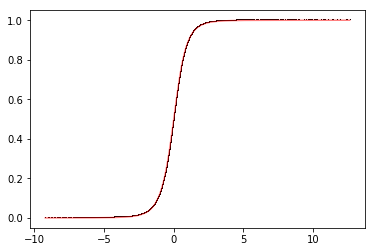

In [9]:
from utils import ecdf

S = D # sample
S = (S - S.mean())/S.std()

xs, ys = ecdf(S, interpolate=False)
cdf = sp.interpolate.interp1d(xs, ys)

X = np.linspace(S.min(), S.max(), 200)
pp.plot(xs, ys, "k,")
pp.plot(X, cdf(X), "r", alpha=0.5)

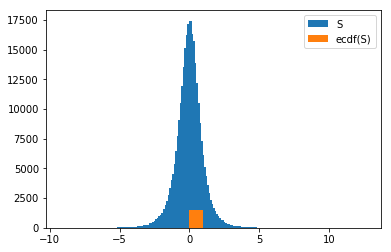

In [10]:
pp.hist(S, bins=200, label="S")
pp.hist(cdf(S), bins=200, label="ecdf(S)")
pp.legend()
None

In [11]:
from joblib import Parallel, delayed

In [12]:
from scipy.stats import rankdata, distributions
# https://github.com/scipy/scipy/pull/3659
# https://github.com/astronomeralex/scipy/blob/002b7084faf938a214ff4f94774bc6b7b0e4c105/scipy/stats/stats.py
def cramer_vonmises_2samp(x, y): # taken from scipy github
    """
    Computes the Cramer von Mises two sample test.
    
    This is a two-sided test for the null hypothesis that 2 independent samples
    are drawn from the same continuous distribution.    
    
    Parameters
    ----------
    x, y : sequence of 1-D ndarrays
        two arrays of sample observations assumed to be drawn from a continuous
        distribution, sample sizes can be different
    Returns
    -------
    T : float
        T statistic
    p-value : float
        two-tailed p-value
    """
    # following notation of Anderson et al. doi:10.1214/aoms/1177704477
    N = len(x)
    M = len(y)
    alldata = np.concatenate((x,y))
    allranks = rankdata(alldata)
    ri = allranks[:N]
    sj = allranks[-M:]
    i = rankdata(x)
    j = rankdata(y)
    # Anderson et al. Eqn 10
    U = N*np.sum((ri - i)**2) + M*np.sum((sj - j)**2)
    # Anderson et al. Eqn 9
    T = U/(N * M * (N + M)) - (4 * M * N - 1)/(6 * (M + N))
    Texpected = 1/6 + 1/(6 * (M + N))
    Tvariance = 1/45 * (M + N + 1)/(M + N)**2 * (4 * M * N * (M+N) - 3*(M**2 + N**2) - 2*M*N)/(4 * M * N)
    zscore = np.abs(T - Texpected) / np.sqrt(Tvariance)
    return T, 2*distributions.norm.sf(zscore)

In [21]:
def vis(T):
    iname, idist, ipars, irmse, imae, iks, ivm, iad = range(8)
    names = np.array([t[iname] for t in T])
    rmse = np.array([t[irmse] if not np.isnan(t[irmse]) else np.inf for t in T])
    ks = np.array([t[iks][-1] if isinstance(t[iks], tuple) and 0.0 <= t[iks][-1] <= 1.0 else 0.0 for t in T])
    vm = np.array([t[ivm][-1] if isinstance(t[ivm], tuple) and 0.0 <= t[ivm][-1] <= 1.0 else 0.0 for t in T])
    ad = np.array([t[iad][-1] if isinstance(t[iad], tuple) and 0.0 <= t[iad][-1] <= 1.0 else 0.0 for t in T])

    top = 50
    n = 7
    pp.figure(figsize=(10,0.24*min(top, len(T))))

    ax = pp.subplot2grid((1,n), (0,2))
    L = rmse
    I = np.argsort(L)[::-1][-top:]
    X = np.arange(len(I))
    ax.plot(L[I], X, "b", label="rmse")
    pp.yticks(X, names[I])
    pp.title("rmse")
    
    ax = pp.subplot2grid((1,n), (0,0))
    L = vm
    I = np.argsort(L)[-top:]
    X = np.arange(len(I))
    ax.plot(L[I], X, "b", label="vm p")
    pp.title("vm")
    pp.yticks(X, names[I])
    
    ax = pp.subplot2grid((1,n), (0,4))
    L = ks
    I = np.argsort(L)[-top:]
    X = np.arange(len(I))
    ax.plot(L[I], X, "b", label="ks")
    pp.yticks(X, names[I])
    pp.title("ks")

    ax = pp.subplot2grid((1,n), (0,6))
    L = ad
    I = np.argsort(L)[-top:]
    X = np.arange(len(I))
    ax.plot(L[I], X, "b", label="ad")
    pp.yticks(X, names[I])
    pp.title("ad")

# vis(T4)

In [42]:
def mle_params(name, dist, S):
    try:
        return name, dist, dist.fit(S.copy())
    except:
        return "error"
    
def compare_dists(T, S, trueX, trueY, method="cdf"):
    T, S, trueX, trueY = (A.copy() for A in (T, S, trueX, trueY))
    nextT = []
    for i,(name, dist, pars, *_) in enumerate(T):
        if i%5 == 0:
            if i > 0: pp.show()
            pp.figure(figsize=(14, 2.5))
        ax = pp.subplot(1,5,i%5+1)
        ax.set_xticks([])
        ax.set_title(name)
        if not isinstance(pars, str):
            ks, vm, ad = [-1.0], [-1.0], [-1.0] # -1 as error value, easy to filter out
            try:
                Y = dist.cdf(trueX, *pars)
                
                if method == "cdf":
                    ax.plot(trueX, trueY, "k")
                    ax.plot(trueX, Y, "r")
                elif method == "hist":
                    ax.hist(dist.cdf(S, *pars), bins=100, normed=True)
                else:
                    raise ValueError("invalid method, must be 'hist' or 'cdf'")

                rmse = ((trueY - Y)**2).mean()**0.5
                mae = np.abs(trueY - Y).mean()
                ks = sp.stats.kstest(S, dist.cdf, args=pars)
                sample = dist.rvs(*pars, size=len(S))
                vm = cramer_vonmises_2samp(S, sample)
                ad = sp.stats.anderson_ksamp([S, sample])

            except Exception as e:
#                 plot_text("didn't work")
                pass
            
            nextT += [[name, dist, pars, rmse, mae, ks, vm, ad]]
            ax.set_xlabel("{:e} rmse\n{:e} ks\n{:e} vm\n{:e} ad".format(rmse, ks[-1], vm[-1], ad[-1]))
        else:
            plot_text("didn't work")
    pp.show()
    return nextT

# compare_dists(T4, S, *ecdf(S, interpolate=False), method="hist")
# None

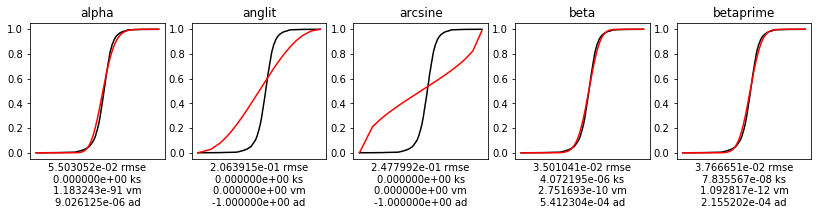

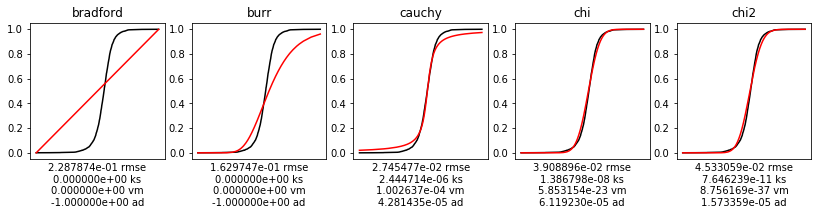

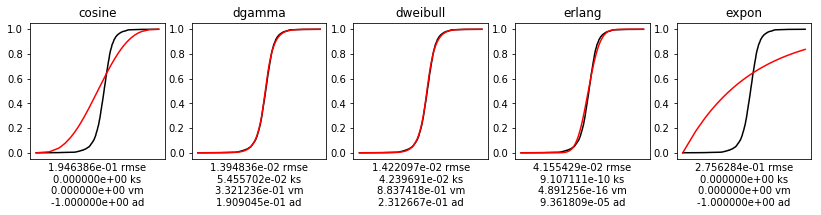

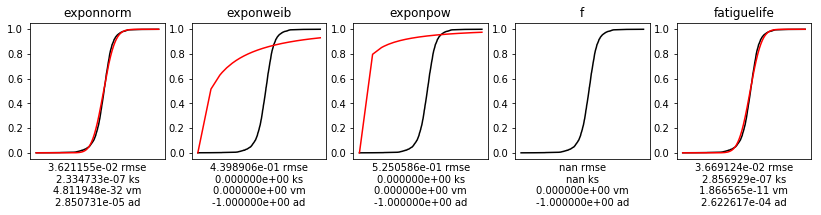

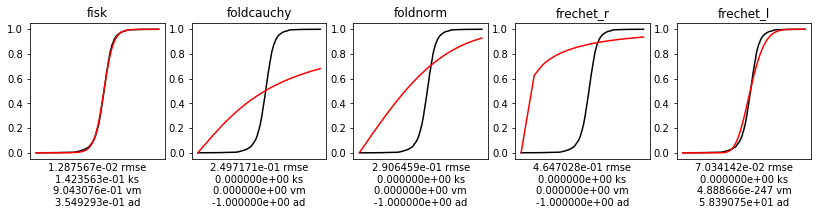

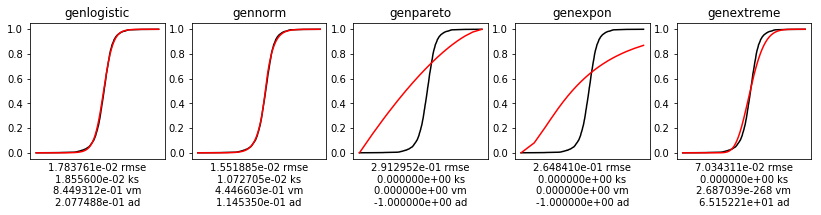

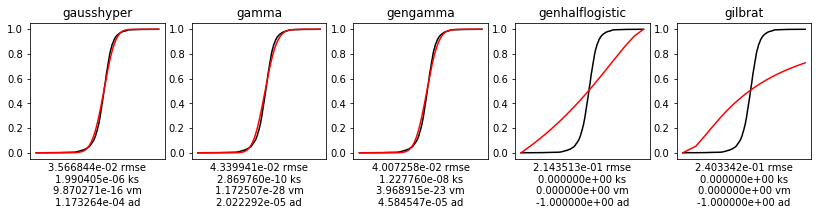

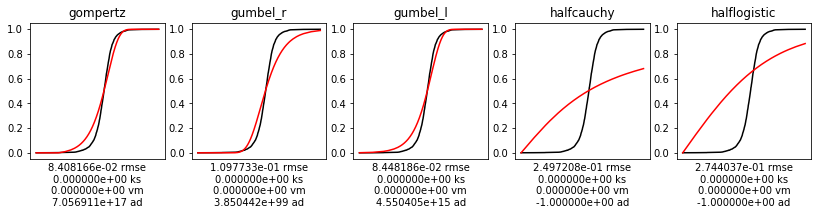

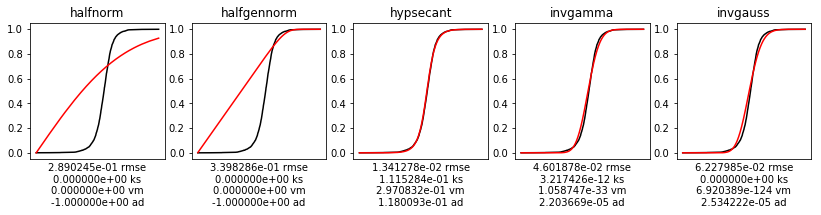

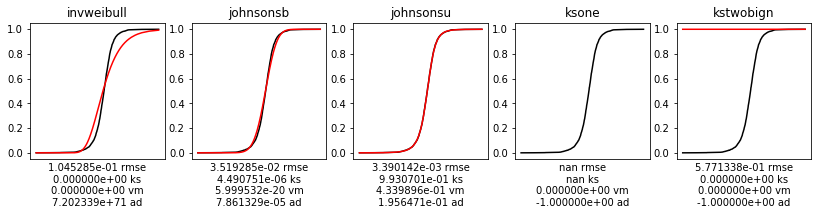

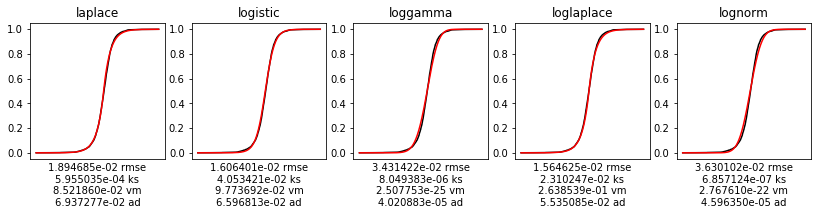

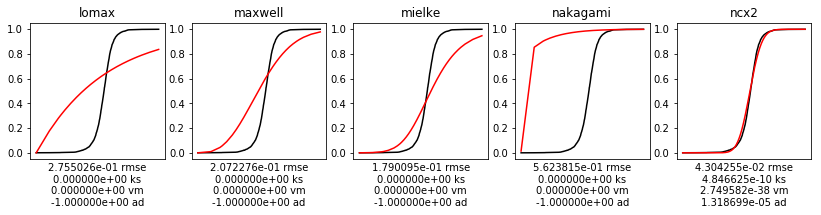

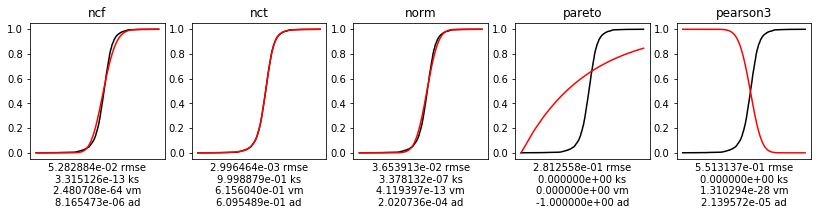

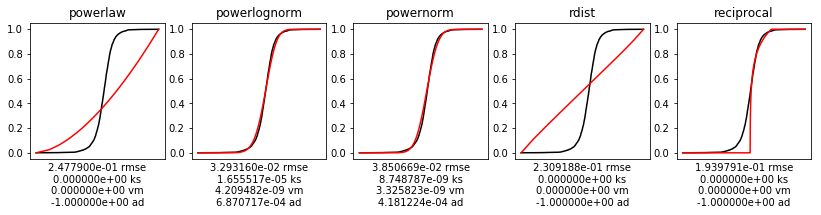

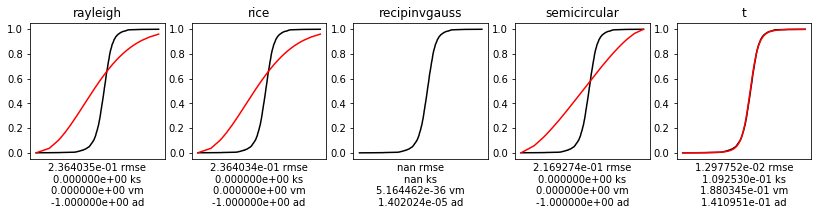

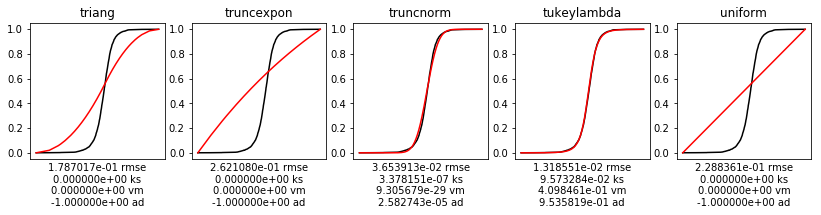

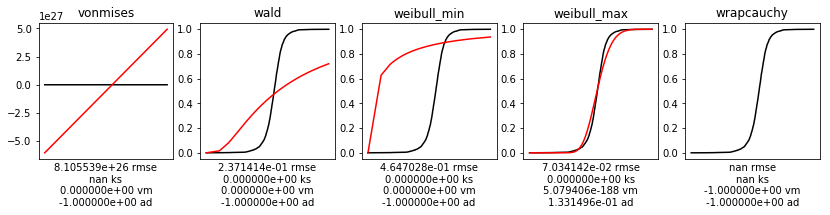

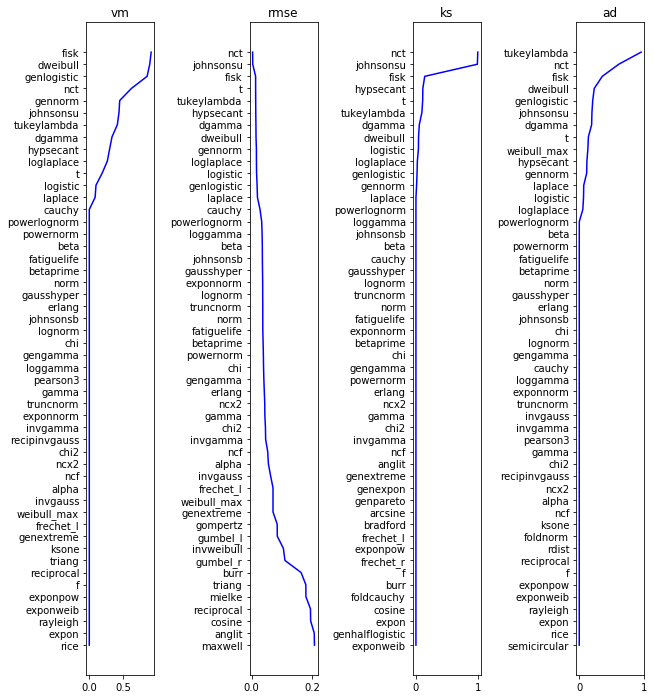

In [91]:
S = np.random.choice(D, size=2000, replace=True)
S = (S - S.mean())/S.std()
T0 = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist in dists)
T0 = compare_dists(T0, S, *ecdf(S, interpolate=False), method='cdf')
vis(T0)

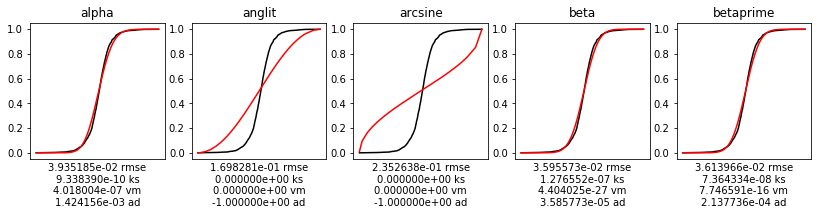

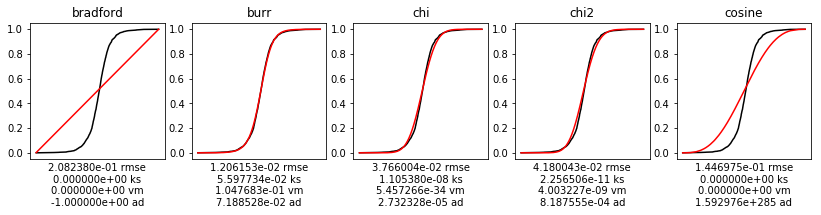

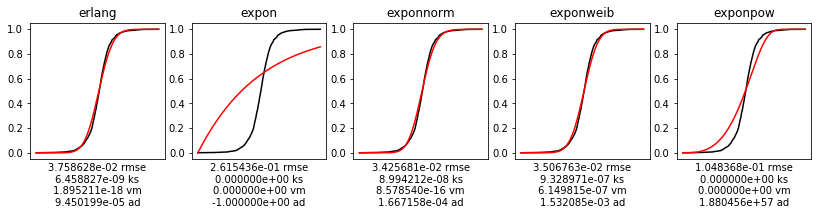

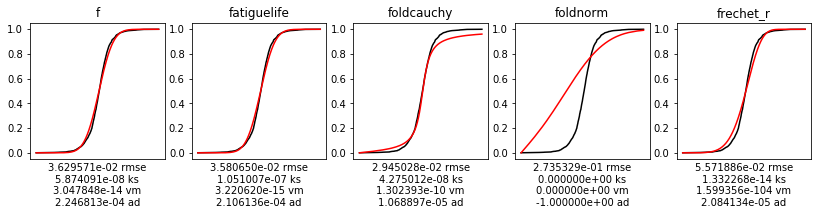

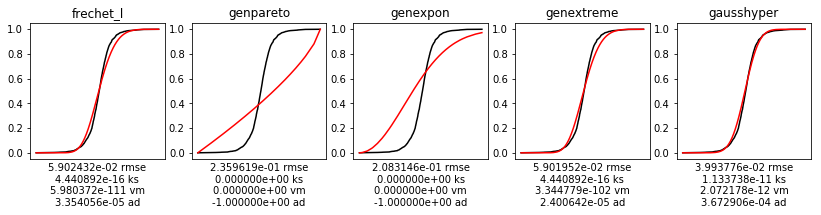

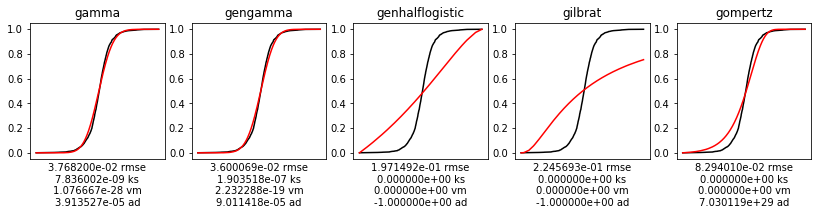

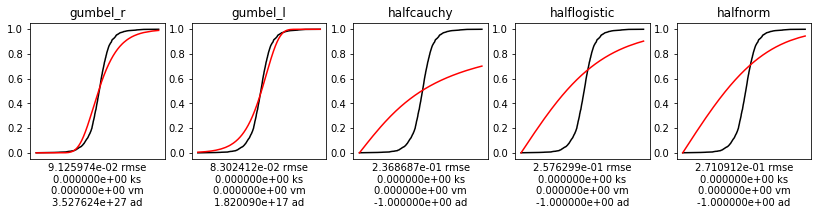

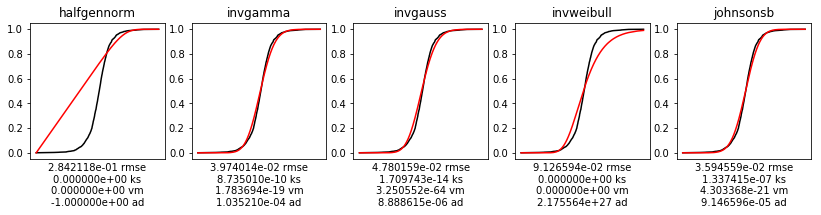

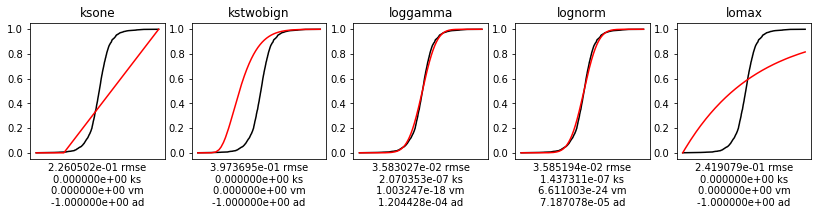

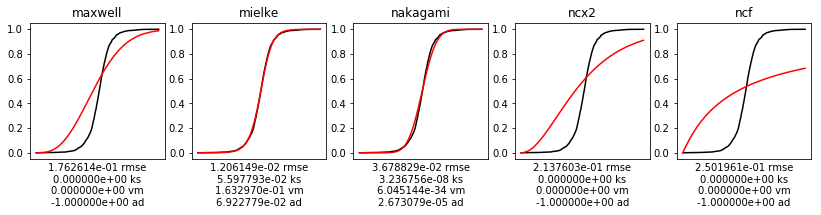

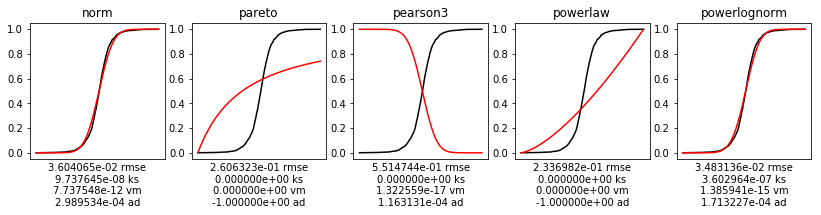

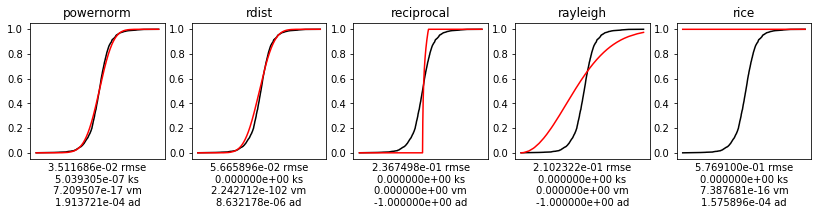

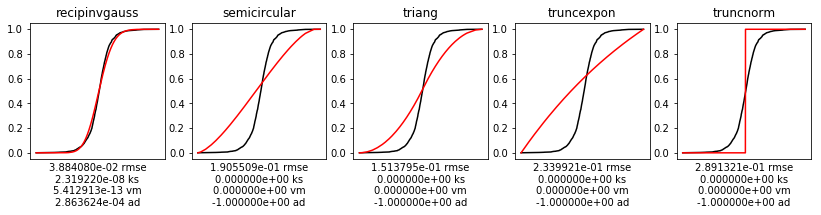

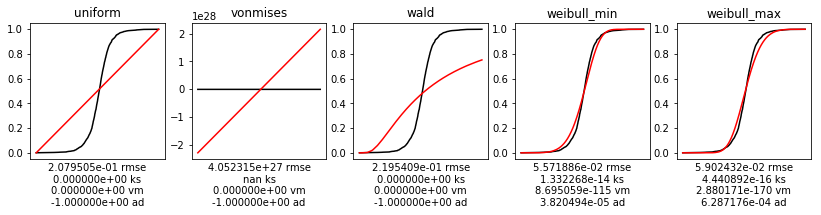

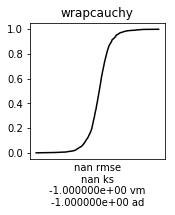

In [92]:
S = np.random.choice(D, size=2000, replace=True)
badT = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T0 if r[-2][-1] <= 1e-8)
badT = compare_dists(badT, S, *ecdf(S, interpolate=False), method='cdf')
T0 += [t for t in badT if t[-2][-1] > 1e-8]

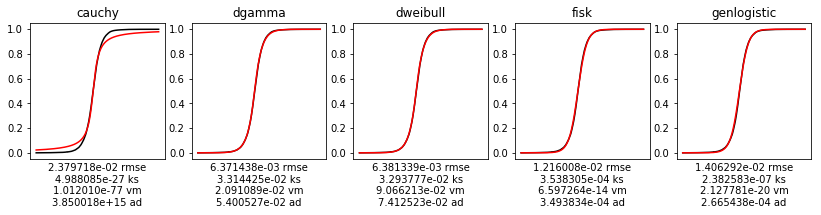

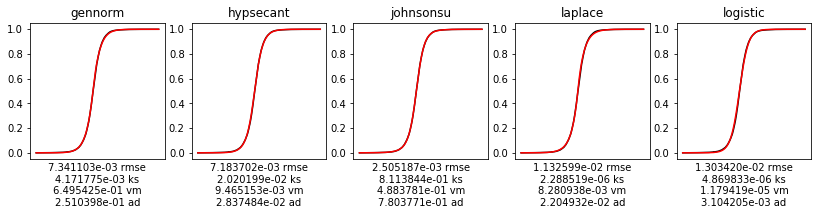

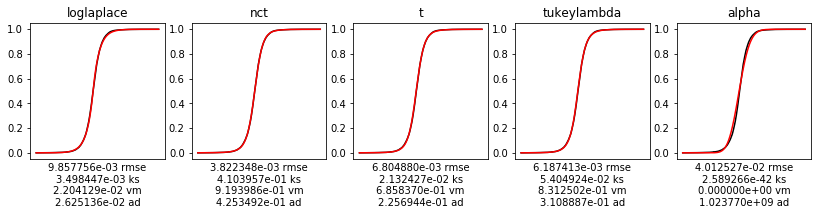

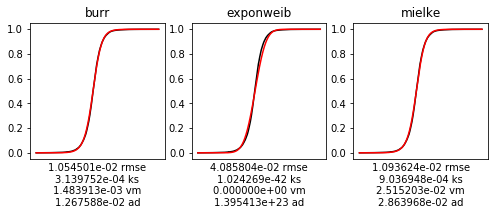

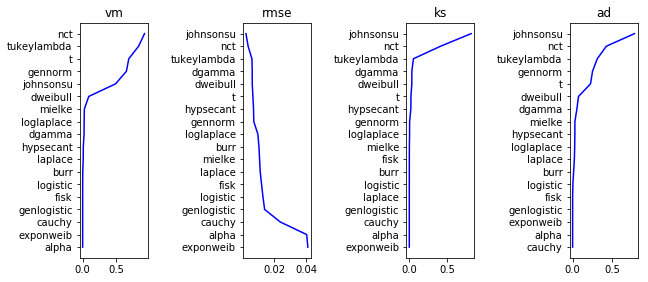

In [93]:
# for name, dist, *r in T0:
#     # [..., ks, vm, ad]
#     if r[-2][-1] > 1e-8: print(name, r[-3][-1], r[-2][-1], r[-1][-1])
#     else: print("-", name)
    
S = np.random.choice(D, size=10000, replace=True)
S = (S - S.mean())/S.std()
T1 = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T0 if r[-2][-1] > 1e-8)
T1 = compare_dists(T1, S, *ecdf(S, interpolate=False), method='cdf')
vis(T1)

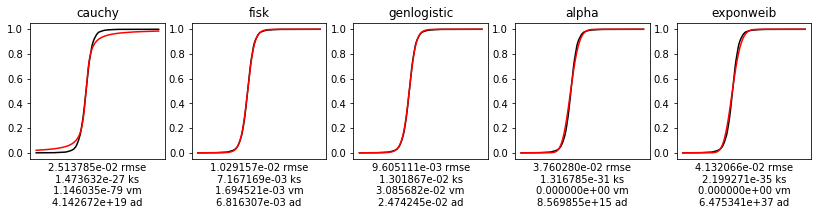

In [94]:
S = np.random.choice(D, size=10000, replace=True)
badT = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T1 if r[-2][-1] <= 1e-8)
badT = compare_dists(badT, S, *ecdf(S, interpolate=False), method='cdf')
T1 += [t for t in badT if t[-2][-1] > 1e-8]

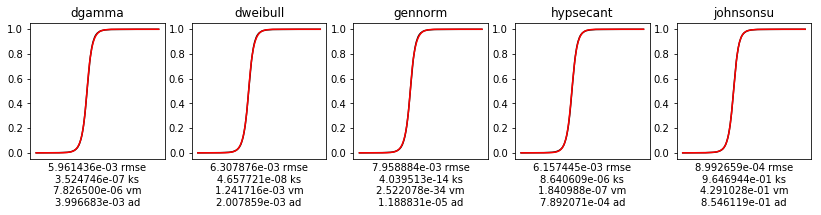

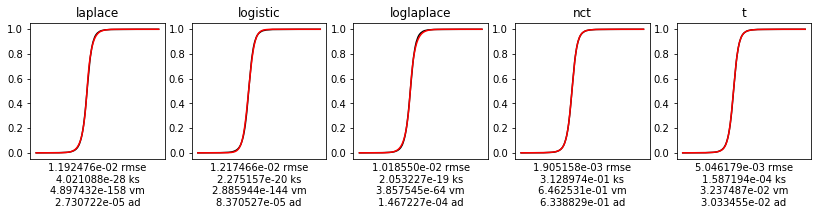

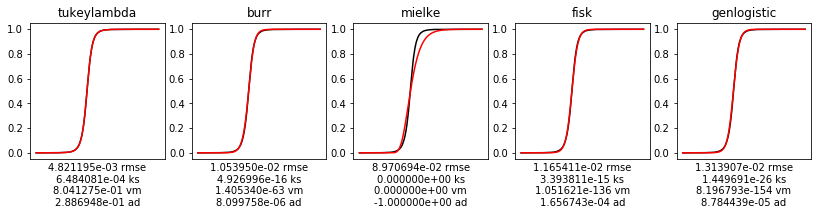

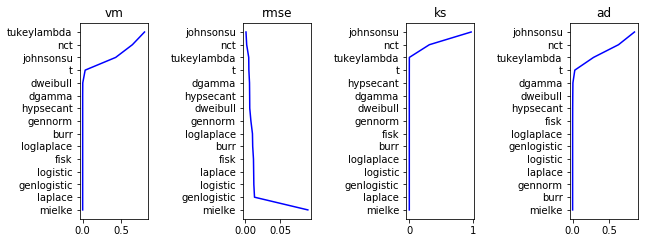

In [95]:
S = np.random.choice(D, size=50000, replace=True)
S = (S - S.mean())/S.std()
T2 = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T1 if r[-2][-1] > 1e-8)
T2 = compare_dists(T2, S, *ecdf(S, interpolate=False))
vis(T2)

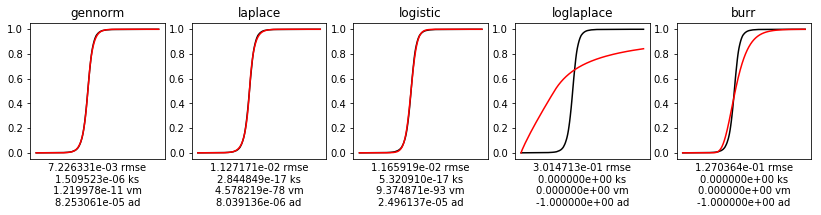

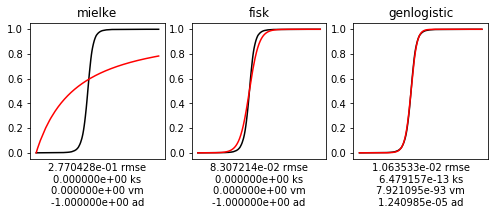

In [96]:
S = np.random.choice(D, size=50000, replace=True)
badT = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T2 if r[-2][-1] <= 1e-8)
badT = compare_dists(badT, S, *ecdf(S, interpolate=False), method='cdf')
T2 += [t for t in badT if t[-2][-1] > 1e-8]

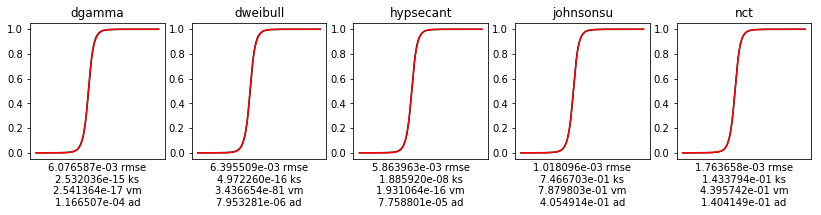

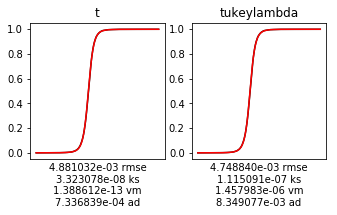

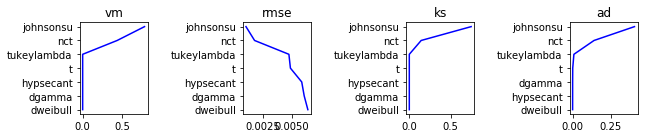

In [97]:
S = np.random.choice(D, size=100000, replace=True)
S = (S - S.mean())/S.std()
T3 = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T2 if r[-2][-1] > 1e-8)
T3 = compare_dists(T3, S, *ecdf(S, interpolate=False))
vis(T3)

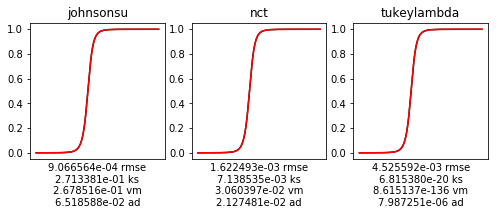

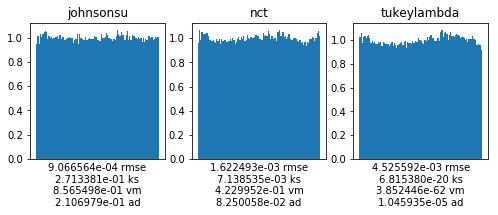

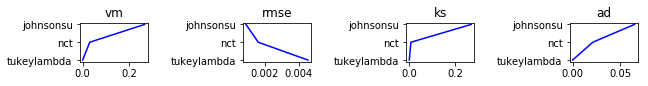

In [98]:
S = D
S = (S - S.mean())/S.std()
T4 = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T3 if r[-2][-1] > 1e-8)
T4 = compare_dists(T4, S, *ecdf(S, interpolate=False))
compare_dists(T4, S, *ecdf(S, interpolate=False), method="hist")
vis(T4)

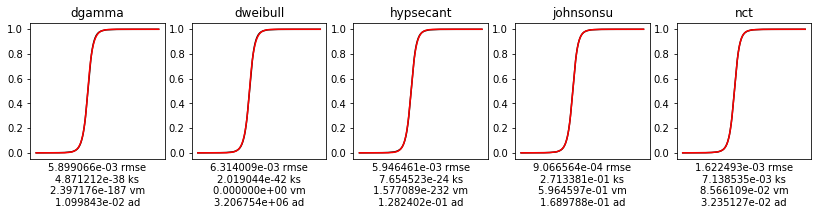

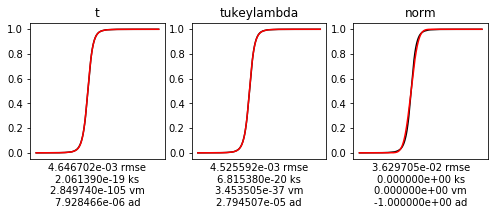

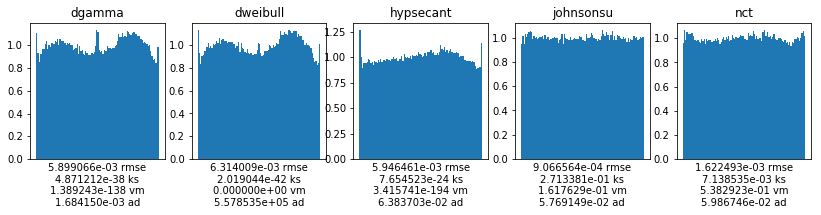

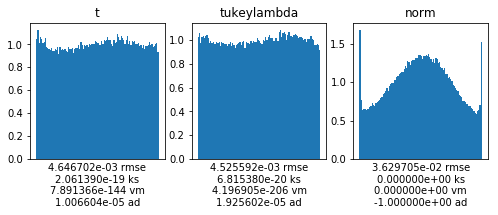

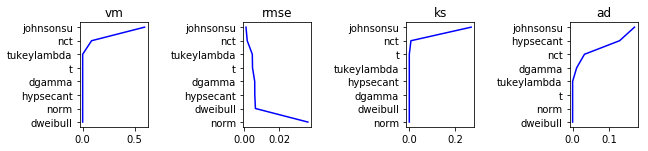

In [99]:
compareto = [
    ("norm", sp.stats.norm)
]
S = D
S = (S - S.mean())/S.std()
T = Parallel(cores)(delayed(mle_params)(name, dist, S) for name, dist, *r in T3 + compareto)
T = compare_dists(T, S, *ecdf(S, interpolate=False))
compare_dists(T, S, *ecdf(S, interpolate=False), method="hist")
vis(T)

In [102]:
T4[1][2]

(3.917078338515775,
 -0.098296124623427683,
 0.08636855862987769,
 0.71027424617842827)